In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.dates as mdates

# Data Preprocessing

## Price and load

In [ ]:
# Price data
# Using WEP as it reflects the total price including administrative, generation, etc fees

price  = pd.read_csv('../data/wep_aug2023_aug2024.csv', usecols=['Datetime', 'total price (c/kWh)', 'half hour']) # total price is inclusive of off-peak and peak transmission tariff
price['Datetime'] = pd.to_datetime(price['Datetime'])


In [ ]:
# Load data
# Import SRLP (Static Residential Load Profile)

# Please note that the SRLP in this file has been normalized to 12 kWh/day that suits a 4-room HDB flat.

load = pd.read_excel('../data/load_composition.xlsx', usecols=['Time', 'SRLP (kWh)', 'Non-flexible Load (kWh)', 'Flexible Load (kWh)'])
load.rename(columns={'SRLP (kWh)': 'load', 'Time': 'half hour'}, inplace=True)

# Adjust the time information
load['half hour'] = pd.to_datetime(load['half hour'], format='%H:%M:%S')
load['half hour'] = load['half hour'].dt.strftime('%H:%M')

In [ ]:
# Merge price and load data in one dataframe
df = price.merge(load, on='half hour', how='left')
df.rename(columns={'total price (c/kWh)': 'dynamic price (c/kWh)'}, inplace=True) # Rename the load_normalized to just load in the new dataframe for brevity
df['month'] = df['Datetime'].dt.to_period('M')

In [ ]:
# Rearrange column order
df = df[['Datetime', 'half hour', 'month', 'dynamic price (c/kWh)', 'load', 'Non-flexible Load (kWh)', 'Flexible Load (kWh)']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


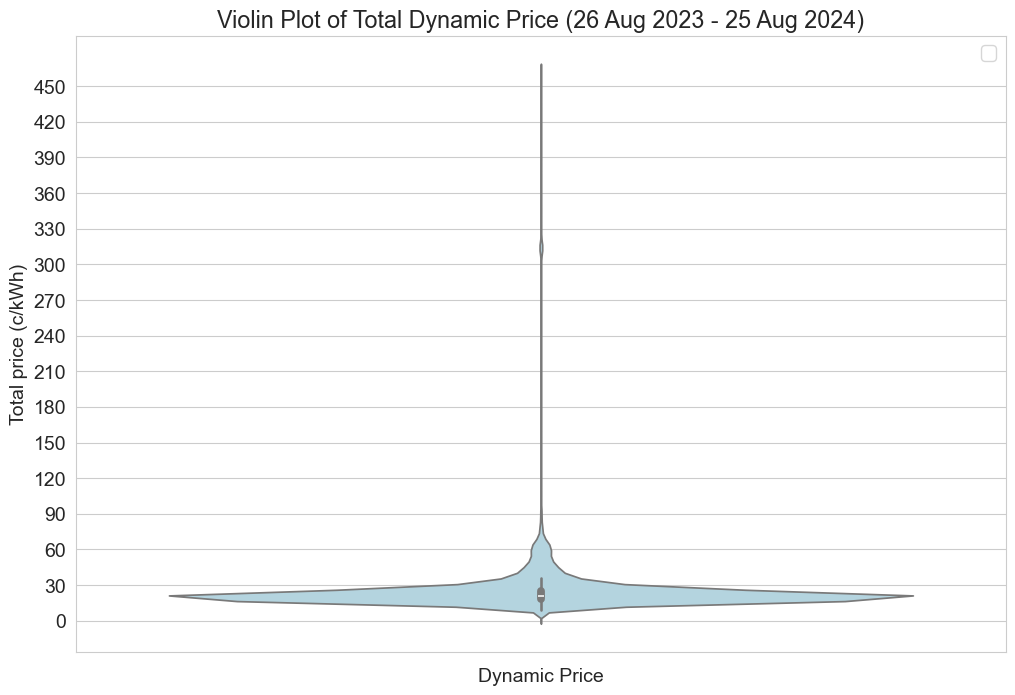

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# Generating the violin plot
violinplot = sns.violinplot(data=df, x=None, y='dynamic price (c/kWh)', ax=ax, inner='box', color='lightblue')

# # Calculating and annotating Q3 and Median
# median_value = round(np.median(df['dynamic price (c/kWh)']), 2)
# q3_value = round(np.percentile(df['dynamic price (c/kWh)'], 75), 2)
#
# ax.axhline(median_value, color='green', linestyle='--', label=f'Median: {median_value}')
# ax.axhline(q3_value, color='red', linestyle='--', label=f'Q3: {q3_value}')

# # Annotating the values on the plot
# ax.text(0.05, median_value, f'Median: {median_value}', verticalalignment='center',
#         fontsize=10, color='green', weight='bold')
# ax.text(0.05, q3_value, f'Q3: {q3_value}', verticalalignment='bottom',
#         fontsize=8, color='red', weight='bold')

ax.set_yticks(np.arange(0, 480, 30))
# Setting titles and labels
ax.set_title('Violin Plot of Total Dynamic Price (26 Aug 2023 - 25 Aug 2024)')
ax.set_xlabel('Dynamic Price')
ax.set_ylabel('Total price (c/kWh)')
ax.legend()

# Display the plot
plt.show()

# Price Sensitivity

## Adding regulated tariff
Regulated tariff changes every quarter of a year. In this step, the corresponding tariff is assigned.

In [ ]:
tariff_intervals = {
    ('2023-08', '2023-09'): 29.96,
    ('2023-10', '2023-12'): 31.00,
    ('2024-01', '2024-03'): 32.58,
    ('2024-04', '2024-06'): 32.47,
    ('2024-07', '2024-09'): 32.57
}

In [ ]:
def assign_tariff(date):
    for (start, end), tariff in tariff_intervals.items():
        if pd.Period(start) <= pd.Period(date, freq='M') <= pd.Period(end):
            return tariff
    return None  # For dates outside the defined intervals

# Add the new column 'regulated tariff (c/kWh)' based on the Datetime column
df['regulated tariff (c/kWh)'] = df['Datetime'].dt.to_period('M').apply(assign_tariff)

In [ ]:
df.head()

,Datetime,half hour,month,dynamic price (c/kWh),load,Non-flexible Load (kWh),Flexible Load (kWh),regulated tariff (c/kWh)
0,2023-08-26 00:00:00,00:00,2023-08,21.268,0.349992,0.0485,0.301492,29.96
1,2023-08-26 00:30:00,00:30,2023-08,21.347,0.332112,0.0485,0.283612,29.96
2,2023-08-26 01:00:00,01:00,2023-08,20.849,0.313464,0.0485,0.264964,29.96
3,2023-08-26 01:30:00,01:30,2023-08,20.809,0.295788,0.0485,0.247288,29.96
4,2023-08-26 02:00:00,02:00,2023-08,20.727,0.280944,0.0485,0.232444,29.96


## Assign adjusted tariff

if $ p \le p_{thresh}, price = p $, else $ price = p_{opmed} $

In [ ]:
# Off-peak tariff and its median
# Off-peak tariff is defined as the period during 23:00 - 07:00. In the dataframe, this translates to time >= 23:00 or time < 07:00

op_tariff_df = df[(df['half hour'] >= '23:00') | (df['half hour'] < '07:00')]
monthly_op_median = op_tariff_df.groupby('month')['dynamic price (c/kWh)'].median()

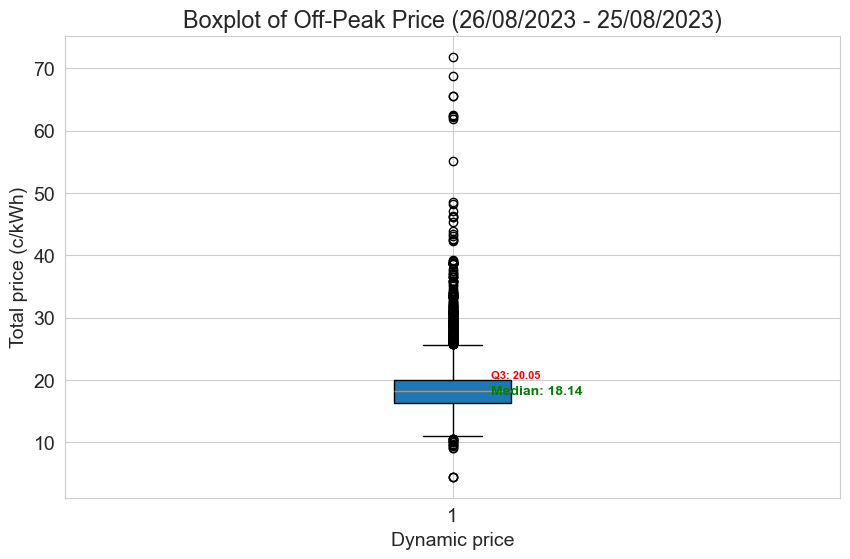

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Generating the boxplot using the Axes object
boxplot = ax.boxplot(op_tariff_df['dynamic price (c/kWh)'], vert=True, patch_artist=True)

# Annotate Q3 and Median
for i, line in enumerate(boxplot['medians']):
    median_value = round(line.get_ydata()[0], 2)
    ax.text(i + 1.05, median_value, f'Median: {median_value}', verticalalignment='center',
            fontsize=10, color='green', weight='bold')

for i, line in enumerate(boxplot['boxes']):
    q3_value = round(np.percentile(op_tariff_df['dynamic price (c/kWh)'], 75), 2)
    ax.text(i + 1.05, q3_value, f'Q3: {q3_value}', verticalalignment='bottom',
            fontsize=8, color='red', weight='bold')

# Setting titles and labels
ax.set_title('Boxplot of Off-Peak Price (26/08/2023 - 25/08/2023)')
ax.set_xlabel('Dynamic price')
ax.set_ylabel('Total price (c/kWh)')

# Display the plot
plt.show()

In [ ]:
df = df.merge(monthly_op_median.rename('Monthly OP Median (c/kWh)'), on='month', how='left')

In [ ]:
df = df[['Datetime', 'half hour', 'month', 'dynamic price (c/kWh)', 'regulated tariff (c/kWh)', 'Monthly OP Median (c/kWh)', 'load',
         'Non-flexible Load (kWh)', 'Flexible Load (kWh)']]

In [ ]:
df.head()

,Datetime,half hour,month,dynamic price (c/kWh),regulated tariff (c/kWh),Monthly OP Median (c/kWh),load,Non-flexible Load (kWh),Flexible Load (kWh)
0,2023-08-26 00:00:00,00:00,2023-08,21.268,29.96,20.724,0.349992,0.0485,0.301492
1,2023-08-26 00:30:00,00:30,2023-08,21.347,29.96,20.724,0.332112,0.0485,0.283612
2,2023-08-26 01:00:00,01:00,2023-08,20.849,29.96,20.724,0.313464,0.0485,0.264964
3,2023-08-26 01:30:00,01:30,2023-08,20.809,29.96,20.724,0.295788,0.0485,0.247288
4,2023-08-26 02:00:00,02:00,2023-08,20.727,29.96,20.724,0.280944,0.0485,0.232444


In [ ]:
# Central difference derivative

def dydx(df, y_column_name, x_column_name = 'Threshold'):
    h = df[x_column_name][1] - df[x_column_name][0]
    if y_column_name == 'dydx':
        df['d2ydx2'] = (df[y_column_name].shift(-1) - df[y_column_name].shift(1)) / (2*h)
        df.loc[[0, 1, len(df)-1, len(df)-2], 'd2ydx2'] = None
    else:
        df['dydx'] = (df[y_column_name].shift(-1) - df[y_column_name].shift(1)) / (2*h)
        df.loc[[0, len(df) - 1], 'dydx'] = None

    return df

## Savings calculation

In [ ]:
# For ease of data viz, create a new dataframe dedicated to bills

bill_df = df.copy()
bill_df = bill_df[['Datetime', 'half hour', 'month']]

In [ ]:
# Regulated bill

bill_df['regulated bill'] = df['load'] * df['regulated tariff (c/kWh)']

In [ ]:
# Define a range of thresholds to test

thresholds = np.arange(20, 505, 5)  # Adjust range and step as needed

# Dictionary to store savings results
savings_results = {}

# Loop over each threshold
for threshold in thresholds:
    # Apply threshold to determine adjusted tariff
    df['adjusted tariff'] = np.where(df['dynamic price (c/kWh)'] <= threshold,
                                                 df['dynamic price (c/kWh)'],
                                                 df['Monthly OP Median (c/kWh)'])

    # Calculate bills based on the adjusted tariff
    bill_df['NF Bill'] = df['Non-flexible Load (kWh)'] * df['dynamic price (c/kWh)']
    bill_df['F Bill'] = df['Flexible Load (kWh)'] * df['adjusted tariff']
    bill_df['App Bill'] = bill_df['NF Bill'] + bill_df['F Bill']

    # Calculate monthly and annual savings
    dynamic_monthly_bill = bill_df.groupby('month')['App Bill'].sum() / 100
    regulated_monthly_bill = bill_df.groupby('month')['regulated bill'].sum() / 100
    annual_saving = (regulated_monthly_bill.values - dynamic_monthly_bill.values).sum()

    # Store the annual saving for this threshold
    savings_results[threshold] = annual_saving

# Convert results to a DataFrame for analysis
savings_df = pd.DataFrame(list(savings_results.items()), columns=['Threshold', 'Annual Savings'])
savings_df = dydx(savings_df, 'Annual Savings')
# savings_df['d2ydx2'] = savings_df['dydx'].diff()/savings_df['Threshold'].diff()
savings_df = dydx(savings_df, 'dydx')



## Usable Hours

In [ ]:
# Create a DataFrame to store daily usable hours for each threshold
daily_usable_hours = pd.DataFrame()
daily_usable_hours_allday = pd.DataFrame()

# Create a complete date range covering all potential dates
full_date_range = pd.date_range(start=df['Datetime'].dt.date.min(), end=df['Datetime'].dt.date.max())

# Loop over each threshold
for threshold in thresholds:
    # Option 1: To exclude off-peak period
    df['usable_hours'] = (
        (df['dynamic price (c/kWh)'] <= threshold) &
        ~((df['half hour'] >= '23:00') | (df['half hour'] < '07:00'))
    )

    # Option 2: To include off-peak period
    df['usable_hours_allday'] = (df['dynamic price (c/kWh)'] <= threshold)

    # Calculate the daily count of usable hours for this threshold
    daily_hours = df[df['usable_hours']].groupby(df['Datetime'].dt.date).size()/2
    daily_hours_allday = df[df['usable_hours_allday']].groupby(df['Datetime'].dt.date).size()/2

    # Reindex to include all dates in the full date range
    daily_hours = daily_hours.reindex(full_date_range, fill_value=0)
    daily_hours_allday = daily_hours_allday.reindex(full_date_range, fill_value=0)

    # Add to the DataFrame with threshold as the column name
    daily_usable_hours[threshold] = daily_hours
    daily_usable_hours_allday[threshold] = daily_hours_allday

In [ ]:
daily_usable_hours_allday_melt = daily_usable_hours_allday.reset_index()
daily_usable_hours_melt = daily_usable_hours.reset_index()


def transform(df):
    new_df = df.melt(
        id_vars=['index'],
        var_name='Threshold',
        value_name='Usable Hours'
    )

    new_df['Threshold'] = pd.to_numeric(new_df['Threshold'], errors='coerce')

    return new_df

daily_usable_hours_allday_melt = transform(daily_usable_hours_allday_melt)
daily_usable_hours_melt = transform(daily_usable_hours_melt)

mean_usable_hours = pd.DataFrame(daily_usable_hours_melt.groupby('Threshold')['Usable Hours'].mean())
mean_usable_hours.reset_index(inplace=True)
mean_usable_hours = dydx(mean_usable_hours, 'Usable Hours')
mean_usable_hours['d2ydx2'] = mean_usable_hours['dydx'].diff()/mean_usable_hours.index.diff()
mean_usable_hours_allday = pd.DataFrame(daily_usable_hours_allday_melt.groupby('Threshold')['Usable Hours'].mean())
mean_usable_hours_allday.reset_index(inplace=True)
mean_usable_hours_allday = dydx(mean_usable_hours_allday, 'Usable Hours')
mean_usable_hours_allday['d2ydx2'] = mean_usable_hours_allday['dydx'].diff()/mean_usable_hours_allday.index.diff()


# Visualization
## Line plot of Savings and Usable Hours

In [ ]:
# # Create the figure and axis objects
# fig, ax = plt.subplots(figsize=(12, 8))
#
# # Plot the data
# ax.plot(savings_df['Threshold'], savings_df['Annual Savings'], marker='o', label='Annual Savings', color='black', alpha=0.6)
#
#
# ax2 = ax.twinx()
# ax2.plot(mean_usable_hours.index, mean_usable_hours, marker='x', color='blue', label='Average Usable Hours (Excluding Off-Peak)', alpha=0.6)
# ax2.plot(mean_usable_hours_allday.index, mean_usable_hours_allday, marker='x', color='red', label='Average Usable Hours (All Day)', alpha=0.6)
#
# # Set titles and labels
# ax.set_title('Annual Savings, Average Usable Hours vs Threshold')
# ax.set_xlim(0, 510)
# ax.set_xlabel('Threshold (c/kWh)')
# ax.set_ylabel('Annual Savings (S$)')
# ax2.set_ylabel('Average Usable Hours')
#
# # Set x-axis ticks every 10 and rotate the labels
# x_ticks = np.arange(0, 511, 10)  # Range from 0 to 510 with a step of 10
# ax.set_xticks(x_ticks)
# ax.tick_params(axis='x', rotation=90)
#
# ax2.set_yticks(np.arange(3, 25, 1))  # Adjust range to match the y-axis range
#
# # Add grid and legend
# ax.grid(True)
# # Get handles and labels from both axes
# handles1, labels1 = ax.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()
#
# # Combine handles and labels
# handles = handles1 + handles2
# labels = labels1 + labels2
#
# # Add a single legend
# ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
#
# # Show the plot
# plt.tight_layout()
# plt.show()

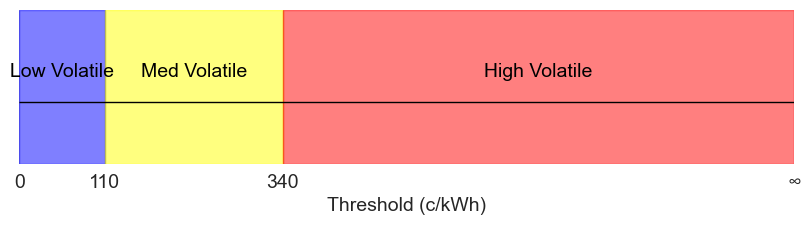

In [ ]:
# Threshold

# Re-import necessary libraries
import matplotlib.pyplot as plt

# Define the updated regions with new boundaries
regions = [
    {"start": 0, "end": 110, "color": "blue", "label": "Low Volatile"},
    {"start": 110, "end": 340, "color": "yellow", "label": "Med Volatile"},
    {"start": 340, "end": 1000, "color": "red", "label": "High Volatile"},  # Representing infinity as a large number
]

# Update max_val to match the new scale
min_val = 0
max_val = 1000

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Plot the number line regions
for region in regions:
    ax.axhspan(0, 1, xmin=region["start"]/max_val, xmax=region["end"]/max_val,
               color=region["color"], alpha=0.5)
    mid_point = (region["start"] + region["end"]) / 2 if region["end"] != 1000 else (region["start"] + max_val) / 2
    label = region["label"] if region["end"] != 1000 else f"{region['label']}"
    ax.text(mid_point, 0.6, label, color="black", ha="center", va="center")  # Adjust annotation position

# Add the number line markers (with infinity as label)
xticks = [0, 110, 340, max_val]
xtick_labels = ["0", "110", "340", "∞"]

ax.hlines(0.4, min_val, max_val, colors="black", linewidth=1)  # Place line lower
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks([])

# Add labels and clean up
ax.set_xlim(min_val, max_val)
ax.set_ylim(0, 1)
ax.set_xlabel("Threshold (c/kWh)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.show()

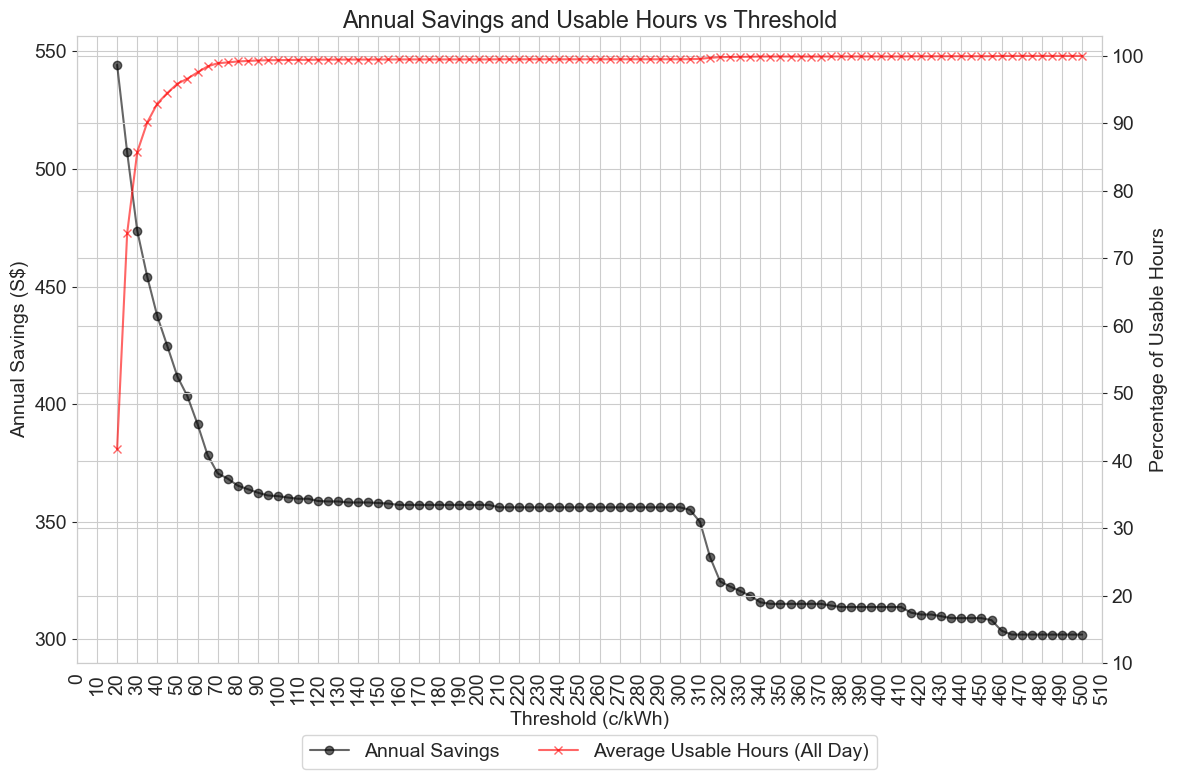

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
ax.plot(savings_df['Threshold'], savings_df['Annual Savings'], marker='o', label='Annual Savings', color='black', alpha=0.6)

ax2 = ax.twinx()
# ax2.plot(mean_usable_hours['Threshold'], mean_usable_hours['Usable Hours']*100/24, marker='x', color='blue', label='Average Usable Hours (Excluding Off-Peak)', alpha=0.6)
ax2.plot(mean_usable_hours_allday['Threshold'], mean_usable_hours_allday['Usable Hours']*100/24, marker='x', color='red', label='Average Usable Hours (All Day)', alpha=0.6)


# Set titles and labels
ax.set_title('Annual Savings and Usable Hours vs Threshold')
ax.set_xlim(0, 510)
ax.set_xlabel('Threshold (c/kWh)')
ax.set_ylabel('Annual Savings (S$)')
ax2.set_ylabel('Percentage of Usable Hours')

# Set x-axis ticks every 10 and rotate the labels
x_ticks = np.arange(0, 511, 10)  # Range from 0 to 510 with a step of 10
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', rotation=90)

ax2.set_yticks(np.arange(10, 101, 10))  # Adjust range to match the y-axis range

# Add grid and legend
ax.grid(True)
# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Add a single legend
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.tight_layout()
plt.show()

## Line Plot of First Derivative of Annual Savings and Usable Hours

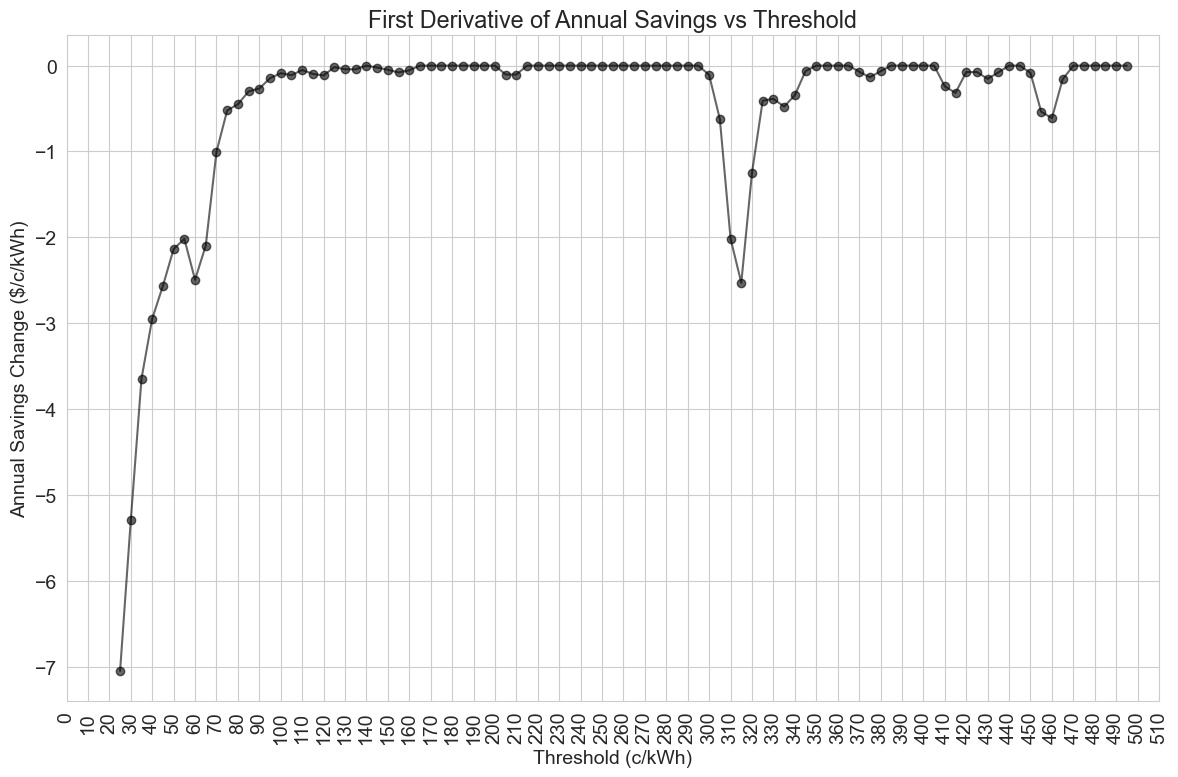

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
ax.plot(savings_df['Threshold'], savings_df['dydx'], marker='o', label='Annual Savings', color='black', alpha=0.6)


# ax2 = ax.twinx()
# ax2.plot(mean_usable_hours['Threshold'], mean_usable_hours['dydx'], marker='x', color='blue', label='Average Usable Hours (Excluding Off-Peak)', alpha=0.6)
# ax2.plot(mean_usable_hours_allday['Threshold'], mean_usable_hours_allday['dydx'], marker='x', color='red', label='Average Usable Hours (All Day)', alpha=0.6)

# ax.axvline(75, ls='--', label='Threshold cut-off')

# Set titles and labels
ax.set_title('First Derivative of Annual Savings vs Threshold')
ax.set_xlim(0, 510)
# ax.set_ylim(1.05*np.min(savings_df['dydx']), 1.05*np.abs(np.min(savings_df['dydx'])))
# ax2.set_ylim(-1.05*np.max(mean_usable_hours_allday['dydx']), 1.05*np.max(mean_usable_hours_allday['dydx']))

ax.set_xlabel('Threshold (c/kWh)')
ax.set_ylabel('Annual Savings Change ($/c/kWh)')
# ax2.set_ylabel('Usable Hours Change (hours/c/kWh)')

# Set x-axis ticks every 10 and rotate the labels
x_ticks = np.arange(0, 511, 10)  # Range from 0 to 510 with a step of 10
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', rotation=90)

# ax2.set_yticks(np.arange(10, 101, 10))  # Adjust range to match the y-axis range

# Add grid and legend
ax.grid(True)
# Get handles and labels from both axes
# handles1, labels1 = ax.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
# handles = handles1 + handles2
# labels = labels1 + labels2

# Add a single legend
# ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
stdev = savings_df['dydx'].std()
mean = savings_df['dydx'].mean()

print(f'stdev = {stdev} \n mean = {mean}')

stdev = 1.1307462975661908 
 mean = -0.47085526192627386


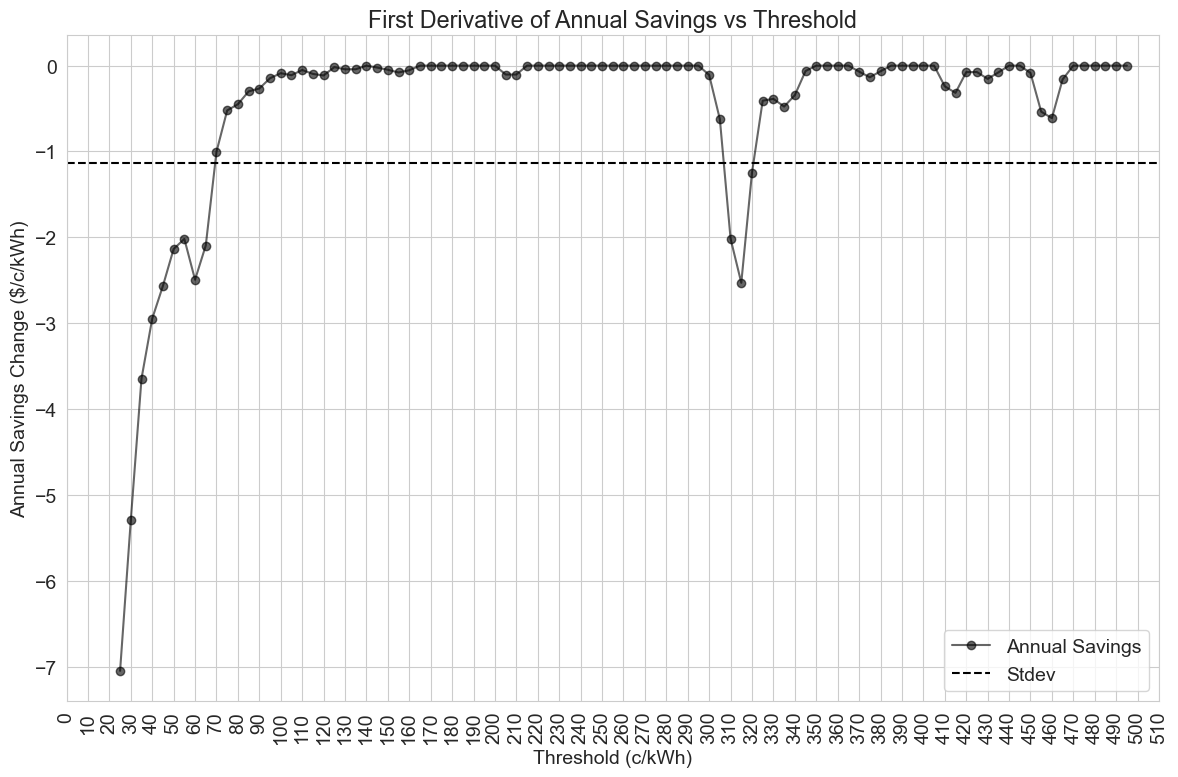

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
ax.plot(savings_df['Threshold'], savings_df['dydx'], marker='o', label='Annual Savings', color='black', alpha=0.6)
ax.axhline(-stdev, linestyle='--', color='black', label='Stdev')


# ax2 = ax.twinx()
# ax2.plot(mean_usable_hours['Threshold'], mean_usable_hours['dydx'], marker='x', color='blue', label='Average Usable Hours (Excluding Off-Peak)', alpha=0.6)
# ax2.plot(mean_usable_hours_allday['Threshold'], mean_usable_hours_allday['dydx'], marker='x', color='red', label='Average Usable Hours (All Day)', alpha=0.6)

# ax.axvline(75, ls='--', label='Threshold cut-off')

# Set titles and labels
ax.set_title('First Derivative of Annual Savings vs Threshold')
ax.set_xlim(0, 510)
# ax.set_ylim(1.05*np.min(savings_df['dydx']), 1.05*np.abs(np.min(savings_df['dydx'])))
# ax2.set_ylim(-1.05*np.max(mean_usable_hours_allday['dydx']), 1.05*np.max(mean_usable_hours_allday['dydx']))

ax.set_xlabel('Threshold (c/kWh)')
ax.set_ylabel('Annual Savings Change ($/c/kWh)')
# ax2.set_ylabel('Usable Hours Change (hours/c/kWh)')

# Set x-axis ticks every 10 and rotate the labels
x_ticks = np.arange(0, 511, 10)  # Range from 0 to 510 with a step of 10
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', rotation=90)

# ax2.set_yticks(np.arange(10, 101, 10))  # Adjust range to match the y-axis range

# Add grid and legend
ax.grid(True)
# Get handles and labels from both axes
# handles1, labels1 = ax.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
# handles = handles1 + handles2
# labels = labels1 + labels2

# Add a single legend
# ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Line Plot of Second Derivative of Annual Savings and Usable Hours

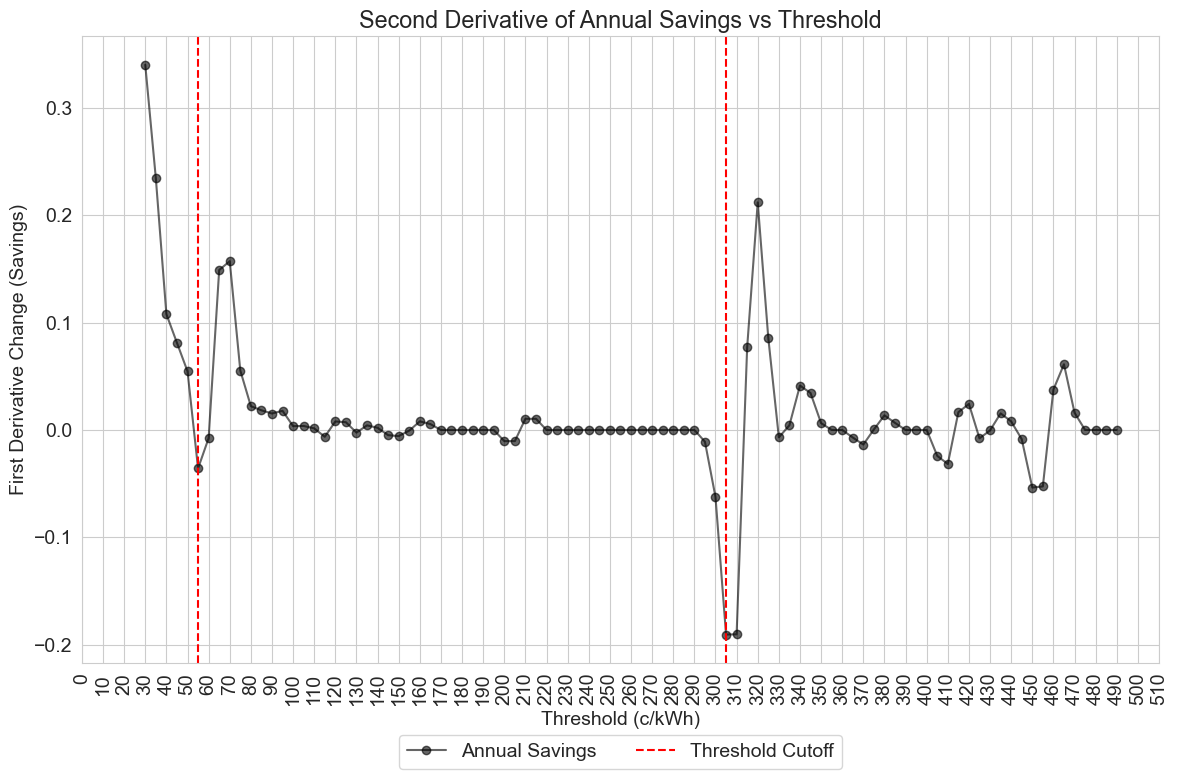

In [ ]:
mask = (savings_df['d2ydx2'] < 0) & (savings_df['d2ydx2'].shift(1) >= 0)

# Select the corresponding Threshold values
cut_off_thresholds = savings_df.loc[mask, 'Threshold']

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
ax.plot(savings_df['Threshold'], savings_df['d2ydx2'], marker='o', label='Annual Savings', color='black', alpha=0.6)
# for threshold in cut_off_thresholds:
#     ax.axvline(threshold, ls='--', color='red', alpha=0.7)

ax.axvline(55, linestyle='--', color='red', label='Threshold Cutoff')
ax.axvline(305, linestyle='--', color='red')

# ax2 = ax.twinx()
# ax2.plot(mean_usable_hours['Threshold'], mean_usable_hours['d2ydx2'], marker='x', color='blue', label='Average Usable Hours (Excluding Off-Peak)', alpha=0.6)
# ax2.plot(mean_usable_hours_allday['Threshold'], mean_usable_hours_allday['d2ydx2'], marker='x', color='red', label='Average Usable Hours (All Day)', alpha=0.6)

# Set titles and labels
ax.set_title('Second Derivative of Annual Savings vs Threshold')
ax.set_xlim(0, 510)
ax.set_xlabel('Threshold (c/kWh)')
ax.set_ylabel('First Derivative Change (Savings)')
# ax2.set_ylabel('First Derivative Change (Usable Hours)')

# Set x-axis ticks every 10 and rotate the labels
x_ticks = np.arange(0, 511, 10)  # Range from 0 to 510 with a step of 10
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', rotation=90)

# ax2.set_yticks(np.arange(10, 101, 10))  # Adjust range to match the y-axis range

# Add grid and legend
ax.grid(True)
# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
# handles = handles1 + handles2
# labels = labels1 + labels2

# Add a single legend
ax.legend(handles1, labels1, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
stdev = savings_df['d2ydx2'].std()
mean = savings_df['d2ydx2'].mean()

print(f'stdev = {stdev} \n mean = {mean}')

stdev = 0.06440510955280415 
 mean = 0.013271189235980667


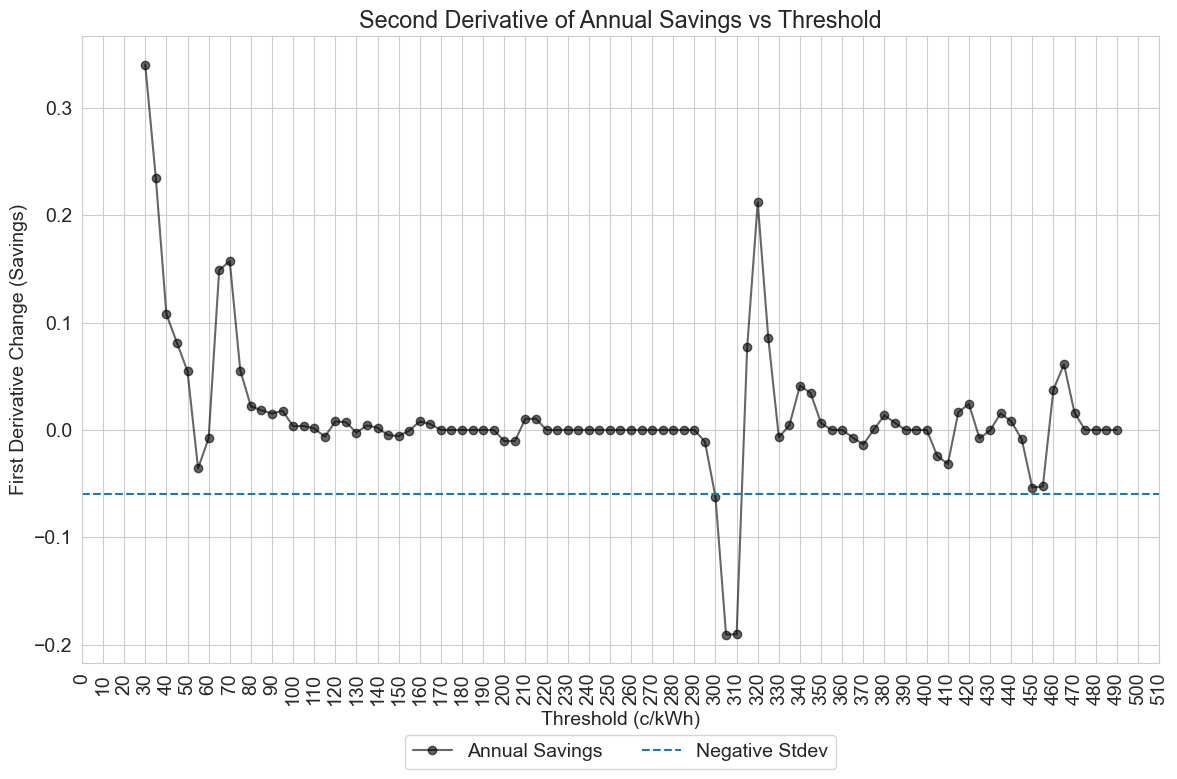

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
ax.plot(savings_df['Threshold'], savings_df['d2ydx2'], marker='o', label='Annual Savings', color='black', alpha=0.6)
ax.axhline(-0.06, ls='--', label='Negative Stdev')



# ax2 = ax.twinx()
# ax2.plot(mean_usable_hours['Threshold'], mean_usable_hours['d2ydx2'], marker='x', color='blue', label='Average Usable Hours (Excluding Off-Peak)', alpha=0.6)
# ax2.plot(mean_usable_hours_allday['Threshold'], mean_usable_hours_allday['d2ydx2'], marker='x', color='red', label='Average Usable Hours (All Day)', alpha=0.6)

# Set titles and labels
ax.set_title('Second Derivative of Annual Savings vs Threshold')
ax.set_xlim(0, 510)
ax.set_xlabel('Threshold (c/kWh)')
ax.set_ylabel('First Derivative Change (Savings)')
# ax2.set_ylabel('First Derivative Change (Usable Hours)')

# Set x-axis ticks every 10 and rotate the labels
x_ticks = np.arange(0, 511, 10)  # Range from 0 to 510 with a step of 10
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', rotation=90)

# ax2.set_yticks(np.arange(10, 101, 10))  # Adjust range to match the y-axis range

# Add grid and legend
ax.grid(True)
# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
# handles = handles1 + handles2
# labels = labels1 + labels2

# Add a single legend
ax.legend(handles1, labels1, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.tight_layout()
plt.show()

## Clustering Analysis

In [ ]:
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as hac

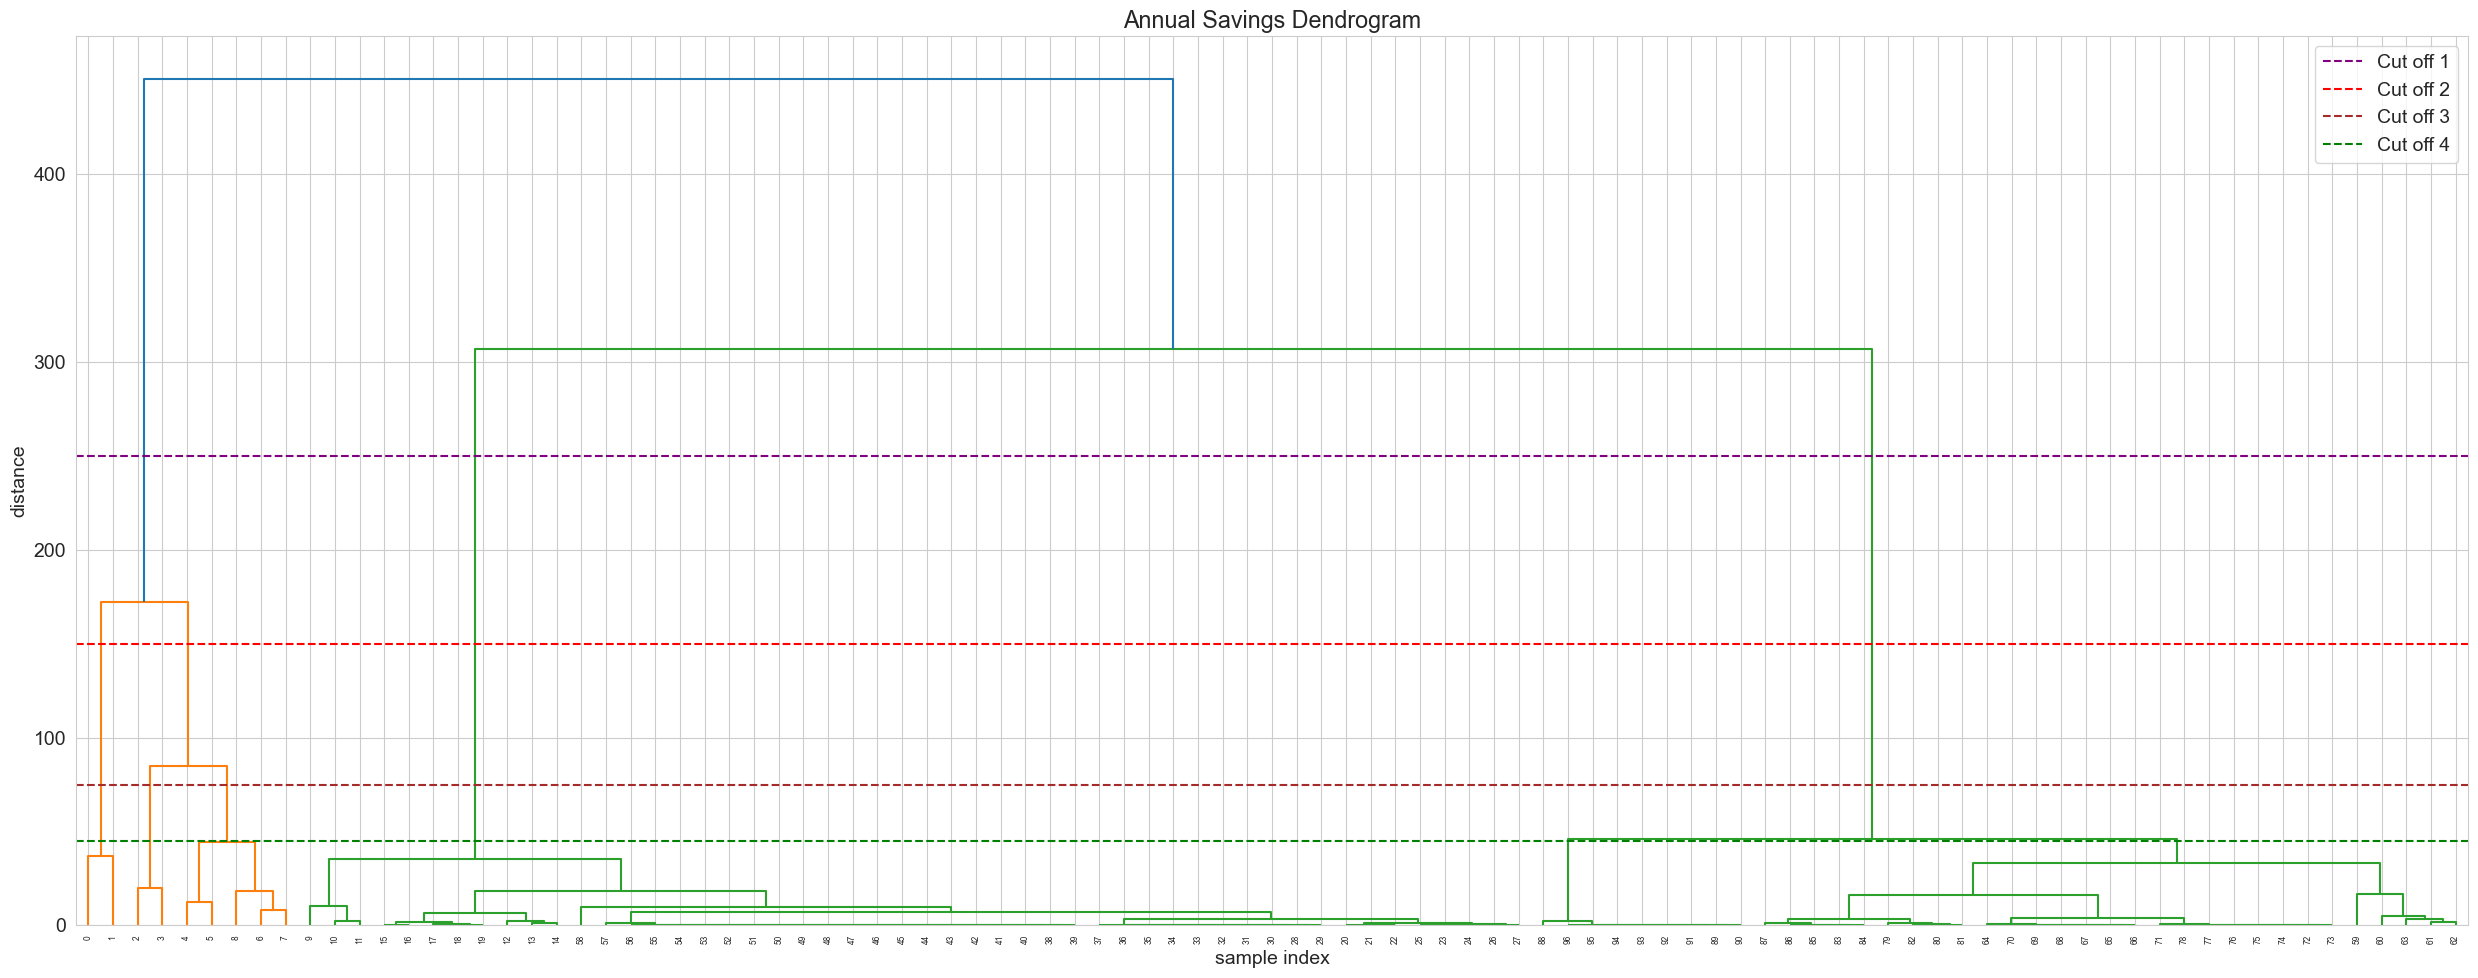

In [ ]:
cluster_data_array = np.array(savings_df['Annual Savings'].values).reshape(-1, 1)

# Dendrogram
Z = hac.linkage(cluster_data_array, method='ward', metric='euclidean')

# Plotting the dendrogram
plt.figure(figsize=(25, 10))
plt.title('Annual Savings Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90,  # rotates the x axis labels
    leaf_font_size=6,  # font size for the x axis labels
)

plt.axhline(250, linestyle='--', color='purple', label='Cut off 1')
plt.axhline(150, linestyle='--', color='red', label='Cut off 2')
plt.axhline(75, linestyle='--', color='brown', label='Cut off 3')
plt.axhline(45, linestyle='--', color='green', label='Cut off 4')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# k Number of clusters I'd like to extract
results = fcluster(Z, 5, criterion='maxclust')

# check the results
s = pd.Series(results)
clusters = s.sort_values().unique()

# Adding the cluster series to the dataframe
savings_df['Cluster'] = s


C:\Users\rezky\AppData\Local\Temp\ipykernel_24356\419359333.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', np.max(savings_df['Cluster'])+1)


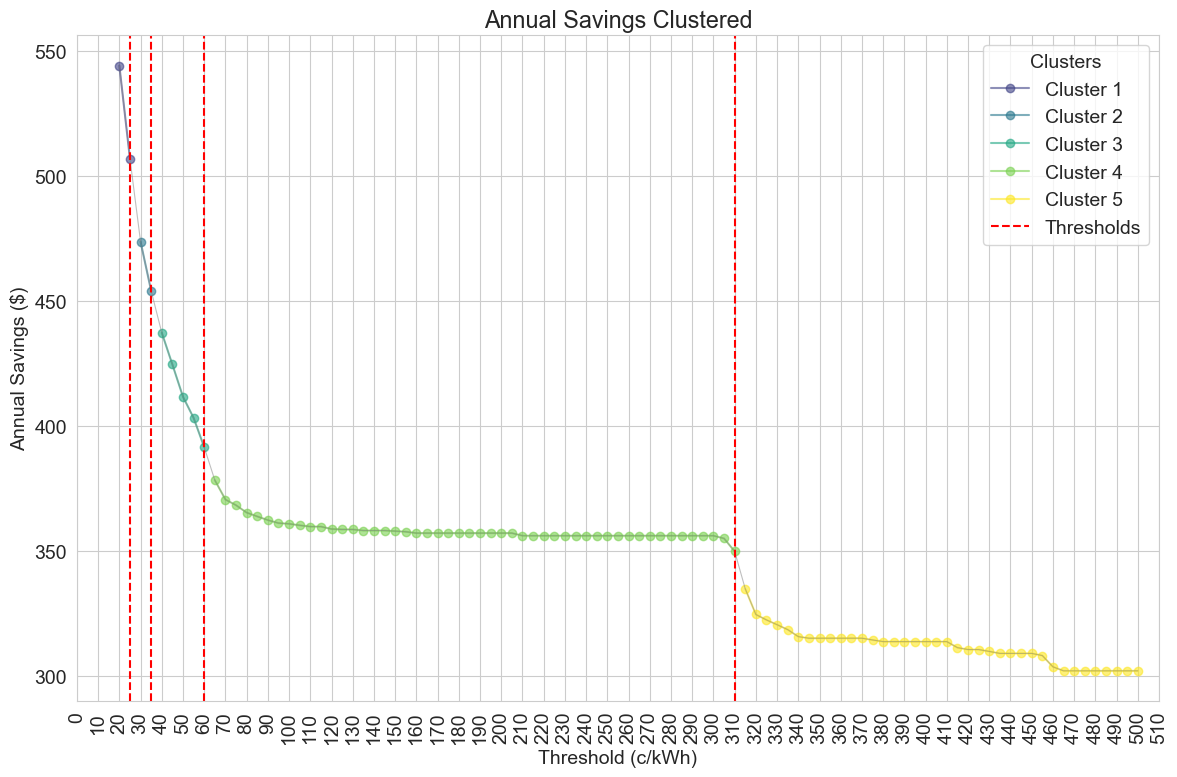

In [ ]:
# Visualization

# Color Mapping
cmap = plt.cm.get_cmap('viridis', np.max(savings_df['Cluster'])+1)
cluster_color = {cluster: cmap(cluster) for cluster in clusters}
# cluster_color = savings_df['Cluster'].map(lambda cluster: cmap(cluster))

fig, ax = plt.subplots(figsize=(12, 8))

for cluster, group in savings_df.groupby('Cluster'):
    ax.plot(
        group['Threshold'],
        group['Annual Savings'],
        marker='o',
        label=f'Cluster {cluster}',
        color=cluster_color[cluster],
        alpha=0.6
    )

# Add connecting lines between clusters
ax.plot(
    savings_df['Threshold'],
    savings_df['Annual Savings'],
    color='gray',
    alpha=0.5,
    linestyle='-',
    linewidth=0.8  # Faint connecting lines
)

ax.axvline(25, linestyle='--', color='red')
ax.axvline(35, linestyle='--', color='red')
ax.axvline(60, linestyle='--', color='red')
ax.axvline(310, linestyle='--', color='red', label='Thresholds')
# ax.axvline(460, linestyle='--', color='red')


# Add legend, labels, and title
ax.legend(title='Clusters')

# Set titles and labels
ax.set_title('Annual Savings Clustered')
ax.set_xlim(0, 510)

ax.set_xlabel('Threshold (c/kWh)')
ax.set_ylabel('Annual Savings ($)')

# Set x-axis ticks every 10 and rotate the labels
x_ticks = np.arange(0, 511, 10)  # Range from 0 to 510 with a step of 10
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', rotation=90)

# Add grid and legend
ax.grid(True)

fig.tight_layout()
plt.show()



## Heatmap of usable hours

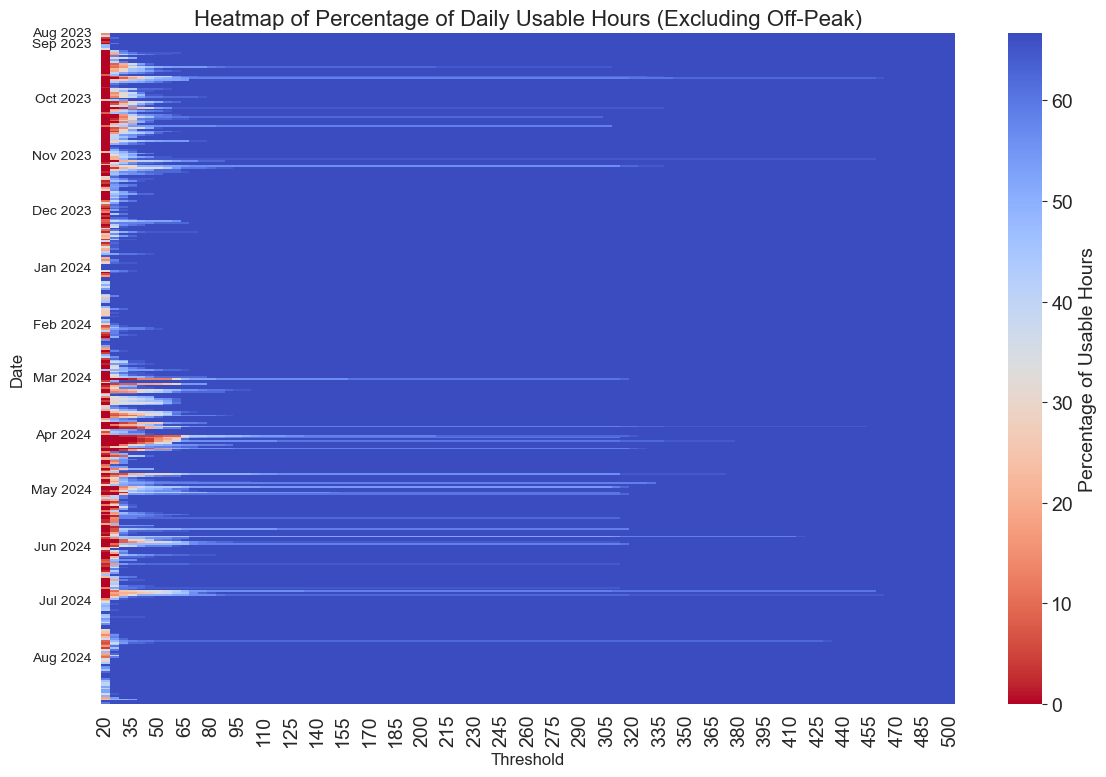

In [ ]:
# Create a heatmap with monthly ticks on the y-axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create the heatmap using Seaborn with inverted colormap
sns.heatmap(daily_usable_hours*100/24,
            ax=ax,
            annot=False,
            cmap='coolwarm_r',  # Use reversed colormap for inversion
            cbar=True,
            cbar_kws={'label': 'Percentage of Usable Hours'},
            vmin=daily_usable_hours.min().min()*100/24,
            vmax=daily_usable_hours.max().max()*100/24)

# Add labels and title
ax.set_title('Heatmap of Percentage of Daily Usable Hours (Excluding Off-Peak)', fontsize=16)
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Date', fontsize=12)

# Select the first date of each month from the existing data
monthly_ticks = daily_usable_hours.index.to_series().groupby(daily_usable_hours.index.to_period('M')).first()

# Set monthly ticks on the y-axis
monthly_positions = [daily_usable_hours.index.get_loc(date) for date in monthly_ticks]
ax.set_yticks(monthly_positions)
ax.set_yticklabels(monthly_ticks.dt.strftime('%b %Y'), rotation=0, fontsize=10)  # Format labels as "Month Year"

# Show the plot
plt.tight_layout()
plt.show()




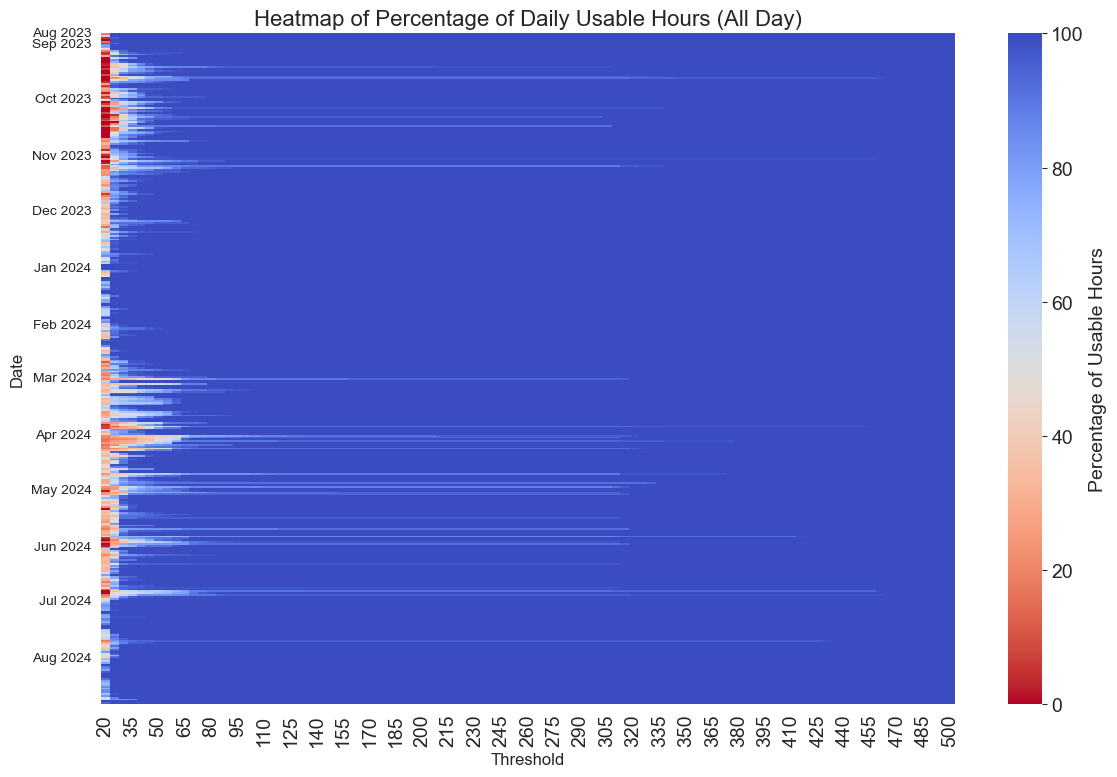

In [ ]:
import seaborn as sns

# Create a heatmap with monthly ticks on the y-axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create the heatmap using Seaborn with inverted colormap
sns.heatmap(daily_usable_hours_allday*100/24,
            ax=ax,
            annot=False,
            cmap='coolwarm_r',  # Use reversed colormap for inversion
            cbar=True,
            cbar_kws={'label': 'Percentage of Usable Hours'},
            vmin=daily_usable_hours_allday.min().min()*100/24,
            vmax=daily_usable_hours_allday.max().max()*100/24)

# Add labels and title
ax.set_title('Heatmap of Percentage of Daily Usable Hours (All Day)', fontsize=16)
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Date', fontsize=12)

# Select the first date of each month from the existing data
monthly_ticks = daily_usable_hours.index.to_series().groupby(daily_usable_hours.index.to_period('M')).first()

# Set monthly ticks on the y-axis
monthly_positions = [daily_usable_hours.index.get_loc(date) for date in monthly_ticks]
ax.set_yticks(monthly_positions)
ax.set_yticklabels(monthly_ticks.dt.strftime('%b %Y'), rotation=0, fontsize=10)  # Format labels as "Month Year"

# Show the plot
plt.tight_layout()
plt.show()


